
# Minimal Bell‑202 FSK: C `demodFSK()` Test
**Three steps only:**
1) Generate FSK (mark=1200 Hz, space=2200 Hz) and quantize to 12‑bit ADC samples.  
2) Compile your **`demod_fsk.c`** into a shared library.  
3) Call `demodFSK(uint16_t)` per sample and plot **input vs output**.


In [25]:
# Build libdemod.so from demod_fsk.c and fir_coefs.h
!gcc -std=c11 -O1 -march=native -fPIC -shared demod_fsk.c -o libdemod.so -lm

print("Compiled libdemod.so")

Compiled libdemod.so


In [26]:
import numpy as np
import ctypes
from matplotlib import pyplot as plt

print("Libraries loaded")

Libraries loaded


In [27]:
# Load the shared library
libdemod = ctypes.CDLL('./libdemod.so')

# Define function signature: float demodFSK(uint16_t adc_value)
libdemod.demodFSK.argtypes = (ctypes.c_uint16,)
libdemod.demodFSK.restype = ctypes.c_float

print("demodFSK() loaded")

demodFSK() loaded


In [28]:
# --- TP3 Parameters ---
Fs       = 12000        # Sampling frequency [Hz]
bps      = 1200         # Bit rate [bits/s]
F_MARK   = 1200         # '1' → 1200 Hz
F_SPACE  = 2200         # '0' → 2200 Hz
amp      = 1.0          # Amplitude (normalized)

# --- Bitstream (from PDF Fig. 7) ---
# bits_str = "11011" * 5
bits_str = "110111111111111100101010101"  # any pattern

print(f"Bitstream: {bits_str[:30]}")

Bitstream: 110111111111111100101010101


In [29]:
# Samples per bit
Ns = int(round(Fs / bps))           # → 10
N  = Ns * len(bits_str)             # Total samples
t  = np.arange(N) / Fs              # Time vector [s]

# Frequency per sample
bits = np.array([b == '1' for b in bits_str], dtype=bool)
freqs = np.where(np.repeat(bits, Ns), F_MARK, F_SPACE)

# Continuous phase FSK
phase = np.cumsum(2 * np.pi * freqs / Fs)
fsk_signal = amp * np.sin(phase)

# Quantize to 12-bit ADC (0–4095)
adc_bits = 12
adc_max = (1 << adc_bits) - 1
adc_signal = np.round((fsk_signal + 1.0) * 0.5 * adc_max).astype(np.uint16)

print(f"Generated {N} samples ({len(bits_str)} bits, {Ns} samples/bit)")

Generated 270 samples (27 bits, 10 samples/bit)


In [30]:
# Output buffer
d_output = np.zeros(N, dtype=np.float32)

print("Running demodFSK() on each ADC sample...")
for i in range(N):
    d_output[i] = libdemod.demodFSK(ctypes.c_uint16(adc_signal[i]))

print("Done.")

Running demodFSK() on each ADC sample...
Done.


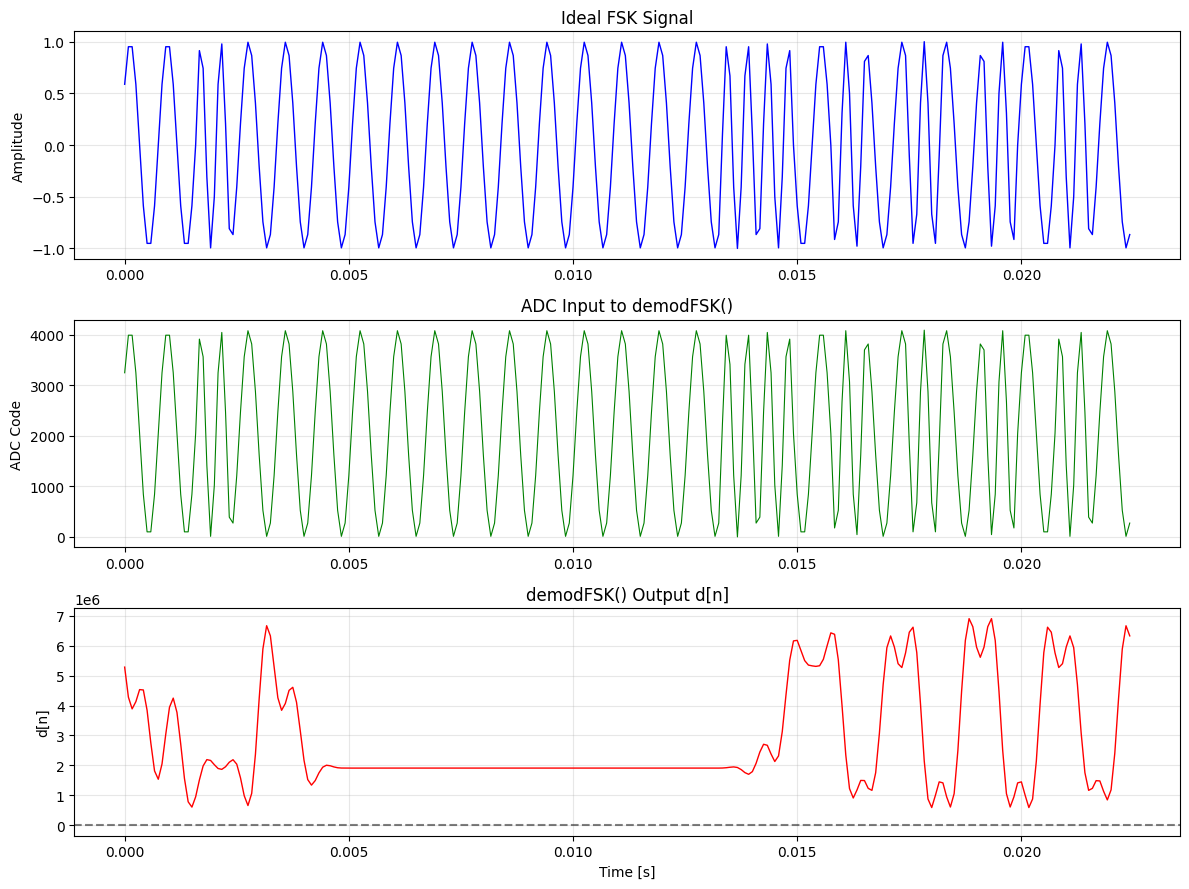

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9))

# 1. Analog FSK
ax1.plot(t, fsk_signal, 'b-', linewidth=1)
ax1.set_title("Ideal FSK Signal")
ax1.set_ylabel("Amplitude")
ax1.grid(alpha=0.3)

# 2. ADC Input
ax2.plot(t, adc_signal, 'g-', linewidth=0.8)
ax2.set_title("ADC Input to demodFSK()")
ax2.set_ylabel("ADC Code")
ax2.grid(alpha=0.3)

# 3. Demod Output
ax3.plot(t, d_output, 'r-', linewidth=1)
ax3.axhline(0, color='k', linestyle='--', alpha=0.5)
ax3.set_title("demodFSK() Output d[n]")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("d[n]")
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
bits_recovered = []
integrator = 0.0
count = 0

for i in range(len(d_output)):
    if i < 17:  # Skip FIR transient
        continue
    integrator += d_output[i]
    count += 1
    if count == Ns:
        bit = 1 if integrator > 0 else 0
        bits_recovered.append(bit)
        integrator = 0.0
        count = 0

print("Original bits: ", bits_str)
print("Recovered:     ", "".join(map(str, bits_recovered)))
print(f"Match: {bits_str == ''.join(map(str, bits_recovered))}")

Original bits:  110111111111111100101010101
Recovered:      1111111111111111111111111
Match: False
